In [2]:
import os
import psycopg
import pandas as pd

TABLE_NAME = 'flats_clean_table'

os.environ["DB_DESTINATION_HOST"] = os.getenv("DB_DESTINATION_HOST")
os.environ["DB_DESTINATION_PORT"] = os.getenv("DB_DESTINATION_PORT")
os.environ["DB_DESTINATION_NAME"] = os.getenv("DB_DESTINATION_NAME")
os.environ["DB_DESTINATION_USER"] = os.getenv("DB_DESTINATION_USER")
os.environ["DB_DESTINATION_PASSWORD"] = os.getenv("DB_DESTINATION_PASSWORD")

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [3]:
df.isna().sum()

id                   0
building_id          0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
price                0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
dtype: int64

In [4]:
df.dtypes

id                     int64
building_id            int64
floor                  int64
kitchen_area         float64
living_area          float64
rooms                  int64
is_apartment          object
studio                object
total_area           float64
price                float64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator          object
dtype: object

In [5]:
from sklearn.preprocessing import KBinsDiscretizer

kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['category'] = kbd.fit_transform(df[['price']])

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

ASSETS_DIR = "assets"

sns.set_style("white")
sns.set_theme(style="whitegrid") 

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

os.makedirs(ASSETS_DIR, exist_ok=True)

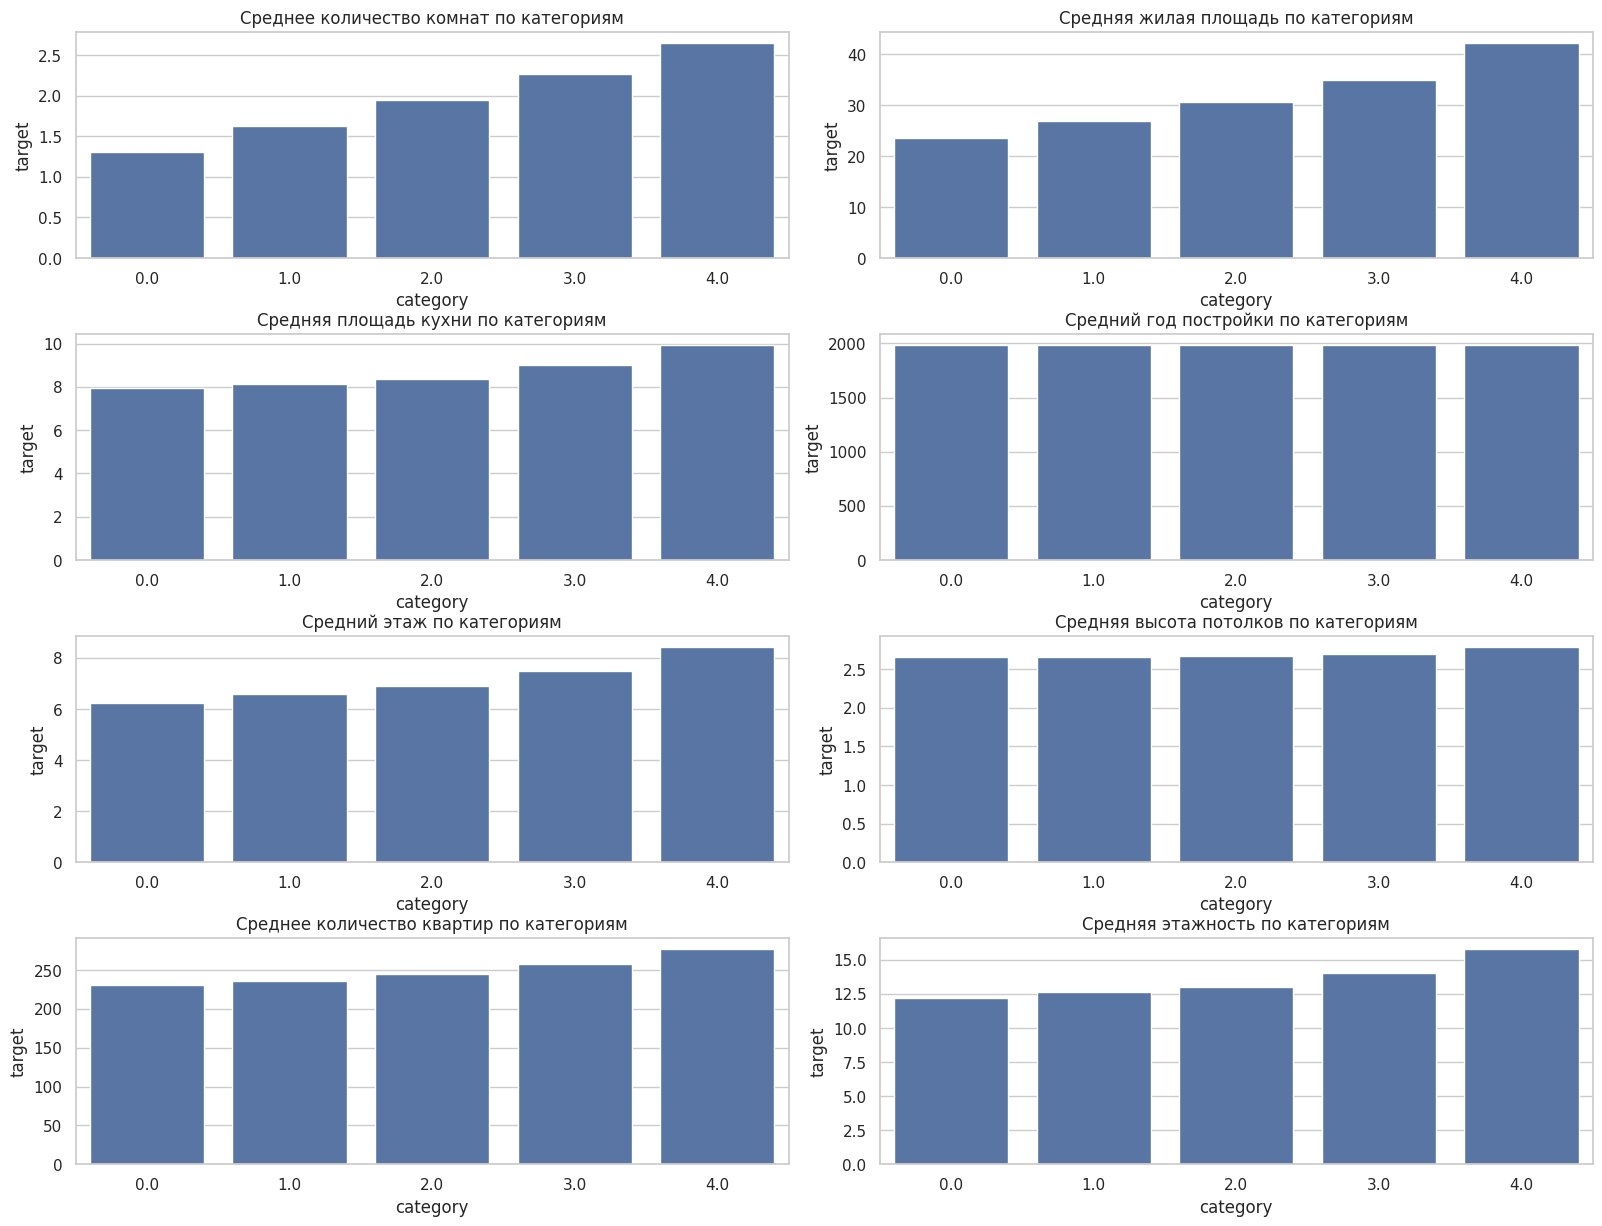

In [7]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=2.5)

x = "category"
y = "rooms"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[0, 0])
axs[0, 0].set_title('Среднее количество комнат по категориям')

y = "living_area"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[0, 1])
axs[0, 1].set_title('Средняя жилая площадь по категориям')

y = "kitchen_area"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[1, 0])
axs[1, 0].set_title('Средняя площадь кухни по категориям')

y = "build_year"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[1, 1])
axs[1, 1].set_title('Средний год постройки по категориям')

y = "floor"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[2, 0])
axs[2, 0].set_title('Средний этаж по категориям')

y = "ceiling_height"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[2, 1])
axs[2, 1].set_title('Средняя высота потолков по категориям')

y = "flats_count"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[3, 0])
axs[3, 0].set_title('Среднее количество квартир по категориям')

y = "floors_total"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[3, 1])
axs[3, 1].set_title('Средняя этажность по категориям')

plt.savefig(os.path.join(ASSETS_DIR,'influence_on_target'))


In [8]:
x = "category"
binary_columns = [
    "is_apartment", 
    "studio", 
    "has_elevator"
]

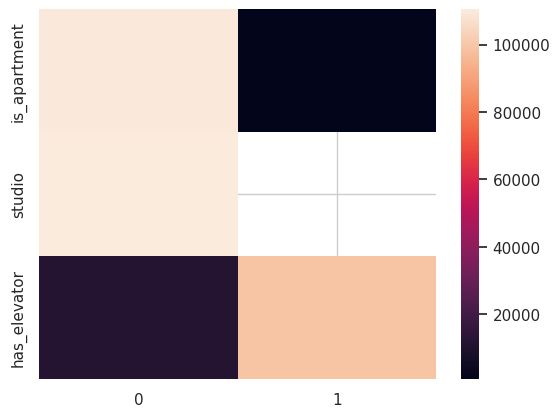

In [9]:
heat_df = df[binary_columns].apply(lambda col: col.apply(lambda x: 1 if x == 'true' else 0))
heat_df = heat_df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR,'heat_map_binary'))


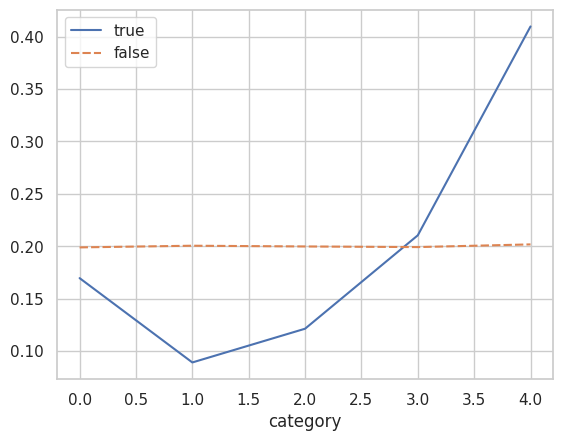

In [58]:
y = "is_apartment"
statist = pd.DataFrame()
statist['true'] = df[x][df[y] == 'true'].value_counts()
statist['true'] /= len(df[x][df[y] == 'true'])
statist['false'] = df[x][df[y] == 'false'].value_counts()
statist['false'] /= len(df[x][df[y] == 'false'])
sns.lineplot(statist)

plt.savefig(os.path.join(ASSETS_DIR,'is_apartment_influence'))



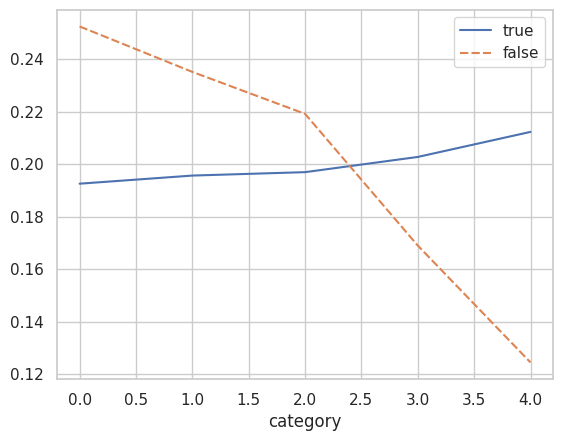

In [59]:
y = "has_elevator"
statist = pd.DataFrame()
statist['true'] = df[x][df[y] == 'true'].value_counts()
statist['true'] /= len(df[x][df[y] == 'true'])
statist['false'] = df[x][df[y] == 'false'].value_counts()
statist['false'] /= len(df[x][df[y] == 'false'])
sns.lineplot(statist)

plt.savefig(os.path.join(ASSETS_DIR,'has_elevator_influence'))



Выводы:
1. Количество комнат имеет значительное влияние на формирование цены
2. Жилая площадь имеет значительное влияние на формирование цены
3. Площадь кухни, этаж, количество этажей, количество квартир имеют влияние на формирование цен, но уже сильно меньшее.
4. Высота потолков, год постройки практически не влияют на формирование цены
5. Есть ли лифт и является ли жилье апартаментами имеет влияние на формирование цены.
6. В выборке очень неравномерное распределение значений бинарных признаков. В датасете совсем нет студий

In [62]:
import mlflow
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_registry_uri(tracking_uri)

In [63]:
EXPERIMENT_NAME = "yandex_realty_aleksandra"
RUN_NAME = 'eda'

In [65]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)
    mlflow.log_artifact("EDA.ipynb")